In [1]:
import torch
from torch import nn

In [2]:
from torch.utils.data import Dataset
from PIL import Image
import os
import torchvision.transforms as T

In [36]:
class CarvanaDataset(Dataset):
    def __init__(self, image_dir, mask_dir=None, img_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform

        self.image_paths = sorted(os.listdir(image_dir))
        self.mask_paths = sorted(os.listdir(mask_dir)) if mask_dir else None

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_paths[idx])
        image = Image.open(img_path).convert("RGB")

        if self.mask_paths:
            mask_path = os.path.join(self.mask_dir, self.mask_paths[idx])
            mask = Image.open(mask_path).convert("L")

            if self.img_transform:
                image = self.img_transform(image)
            if self.mask_transform:
                mask = self.mask_transform(mask)
            return image, mask
        else:
            if self.img_transform:
                image = self.img_transform(image)
            return image

In [18]:
from torch.utils.data import DataLoader
from torchvision.transforms import InterpolationMode

# For images
img_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# For masks
mask_transform = T.Compose([
    T.Resize((256, 256), interpolation=InterpolationMode.NEAREST),
    T.ToTensor(),  # will keep it as float [0,1] with shape [1, H, W]
    T.Lambda(lambda x: (x > 0.5).float())  # binarize mask
])

train_dataset = CarvanaDataset(
    image_dir="train_images",
    mask_dir="train_masks",
    img_transform=img_transform,
    mask_transform=mask_transform
)

test_dataset = CarvanaDataset(
    image_dir="test",
    img_transform=img_transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

In [19]:
print(len(train_loader.dataset))
print(len(test_loader.dataset))

5088
3352


In [20]:
print(len(train_loader))
print(len(test_loader))

1272
838


In [21]:
import cv2
import numpy as np

mask = cv2.imread("train_masks/1c5748340af8_10.png", cv2.IMREAD_GRAYSCALE)
print(np.unique(mask))

[0 1]


In [22]:
images, masks = next(iter(train_loader))
print(images.shape, masks.shape)

torch.Size([4, 3, 256, 256]) torch.Size([4, 1, 256, 256])


In [9]:
def center_crop(encoder_feature, target_tensor):
    _, _, H, W = target_tensor.shape
    enc_H, enc_W = encoder_feature.shape[2], encoder_feature.shape[3]
    crop_H = (enc_H - H) // 2
    crop_W = (enc_W - W) // 2
    return encoder_feature[:, :, crop_H:crop_H+H, crop_W:crop_W+W]

In [10]:
class UNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.encoder2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        self.encoder3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.encoder4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        self.encoder5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
        )


        # Decoder
        self.upconv_1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.decoder1 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        

        self.upconv_2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.decoder2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        

        self.upconv_3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.decoder3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        

        self.upconv_4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.decoder4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)


    def forward(self, image):

        # Encoder
        e1 = self.encoder1(image)
        e2 = self.encoder2(self.max_pool_2x2(e1))
        e3 = self.encoder3(self.max_pool_2x2(e2))
        e4 = self.encoder4(self.max_pool_2x2(e3))
        e5 = self.encoder5(self.max_pool_2x2(e4))

        # Decoder
        d1 = self.upconv_1(e5)
        c1 = center_crop(e4, d1)
        d1 = torch.cat([d1, c1], dim=1)
        d1 = self.decoder1(d1)
        
        d2 = self.upconv_2(d1)
        c2 = center_crop(e3, d2)
        d2 = torch.cat([d2, c2], dim=1)
        d2 = self.decoder2(d2)

        d3 = self.upconv_3(d2)
        c3 = center_crop(e2, d3)
        d3 = torch.cat([d3, c3], dim=1)
        d3 = self.decoder3(d3)

        d4 = self.upconv_4(d3)
        c4 = center_crop(e1, d4)
        d4 = torch.cat([d4, c4], dim=1)
        d4 = self.decoder4(d4)

        # Final output
        out = self.final_conv(d4)

        return out

In [11]:
# Example usage
image = torch.rand((1, 3, 572, 572))
model = UNet()
output = model(image)

In [12]:
output

tensor([[[[-0.1162,  0.9187, -0.2501,  ...,  0.2293, -0.3183,  0.2142],
          [ 0.5234, -0.0483,  0.2741,  ...,  0.1595,  0.1480, -0.2375],
          [-0.3669, -0.0072, -0.2797,  ..., -0.1087,  0.0725,  0.1896],
          ...,
          [ 0.0375,  0.1624, -0.1637,  ...,  0.3474, -0.0643, -0.2824],
          [-0.6788,  0.0158,  0.0904,  ...,  0.2198,  0.0688,  0.1813],
          [-0.0950,  0.2060, -0.1114,  ...,  0.1851,  0.0395,  0.0885]]]],
       grad_fn=<ConvolutionBackward0>)

In [13]:
probs = torch.sigmoid(output)
probs

tensor([[[[0.4710, 0.7148, 0.4378,  ..., 0.5571, 0.4211, 0.5533],
          [0.6280, 0.4879, 0.5681,  ..., 0.5398, 0.5369, 0.4409],
          [0.4093, 0.4982, 0.4305,  ..., 0.4729, 0.5181, 0.5473],
          ...,
          [0.5094, 0.5405, 0.4592,  ..., 0.5860, 0.4839, 0.4299],
          [0.3365, 0.5040, 0.5226,  ..., 0.5547, 0.5172, 0.5452],
          [0.4763, 0.5513, 0.4722,  ..., 0.5461, 0.5099, 0.5221]]]],
       grad_fn=<SigmoidBackward0>)

In [14]:
image = Image.open('0cdf5b5d0ce1_01.jpg').convert('RGB')
input_tensor = transform(image).unsqueeze(0)

NameError: name 'transform' is not defined

In [ ]:
output = model(input_tensor)
probs = torch.sigmoid(output)
probs

In [ ]:
import matplotlib.pyplot as plt
import torch

# Assuming 'probs' is your sigmoid output
# Shape: [1, 1, H, W] or [1, H, W]

# Move tensor to CPU and convert to numpy
mask = probs.squeeze().detach().cpu().numpy()

# Optional: Threshold if you want a binary mask
binary_mask = (mask > 0.5).astype('uint8')

# Plot soft mask (grayscale)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Soft Mask (Probabilities)")
plt.imshow(image, cmap='gray')
plt.axis('off')

# Plot binary mask (thresholded)
plt.subplot(1, 2, 2)
plt.title("Binary Mask (> 0.5)")
plt.imshow(binary_mask, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Generate a fake mask (just for testing visualization)
fake_mask = torch.rand((1, 1, 572, 572))
fake_probs = torch.sigmoid(fake_mask)
fake_binary = (fake_probs > 0.5).float()

# Visualize the fake prediction
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Fake Soft Mask")
plt.imshow(fake_probs.squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Fake Binary Mask")
plt.imshow(fake_binary.squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# from PIL import Image
# import torchvision.transforms as transforms

# # Load the image
# image_path = 'train_images/00087a6bd4dc_01.jpg'  # Replace with your image path
# image = Image.open(image_path).convert('RGB')  # 'RGB' mode converts to grayscale

# # Resize to 572x572 (if your model expects this input)
# transform = transforms.Compose([
#     transforms.Resize((572, 572)),     # Resize to match model input
#     transforms.ToTensor(),             # Converts to tensor and scales to [0,1]
# ])

# # Apply transform
# input_tensor = transform(image)

# # Add batch dimension
# input_tensor = input_tensor.unsqueeze(0)  # Shape: [1, 1, 572, 572]

# print(input_tensor.shape)  # torch.Size([1, 1, 572, 572])

In [ ]:
input_tensor

In [ ]:
output1 = model(input_tensor)

In [ ]:
output1

In [ ]:
output1.shape

In [ ]:
device = "cuda" if torch.cuda.is_available else "cpu"
device

In [ ]:
model = UNet()
model = model.to(device)

In [ ]:
import torch.optim as optim
criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.99)

In [ ]:
def init_weights(module):
    if isinstance(module, torch.nn.Conv2d):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.01)
        if module.bias is not None:
            torch.nn.init.constant_(module.bias, 0)

model.apply(init_weights)

In [ ]:
epochs = 5
batch_size = 4
learning_rate = 0.01
n_train = len(train_loader.dataset)  # or hardcode a value if needed
n_val = len(test_loader.dataset) if 'val_loader' in globals() else 0
save_checkpoint = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_scale = 1.0
amp = False  # or True if you're using mixed precision training

In [ ]:
import logging
import os
import sys
from datetime import datetime
from tqdm.notebook import tqdm 

# Create logs directory
os.makedirs("logs2", exist_ok=True)

# Timestamped log file
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
log_file = f"logs2/train_{timestamp}.log"

# Configure logging
logging.basicConfig(
    filename=log_file,
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s | %(levelname)s | %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)


# Config
epochs = 0  # OR use num_epochs and change below
logging.info(f'''Starting training:
    Epochs:          {epochs}
    Batch size:      {batch_size}
    Learning rate:   {learning_rate}
    Training size:   {n_train}
    Validation size: {n_val}
    Checkpoints:     {save_checkpoint}
    Device:          {device.type}
    Image scaling:   {img_scale}
    Mixed Precision: {amp}
''')

# Training loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    logging.info(f"Epoch {epoch+1}/{epochs} started.")
    print(f"\nEpoch {epoch+1}/{epochs}")
    
    for batch_idx, (images, masks) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        _, _, h, w = outputs.shape
        masks_cropped = masks[:, :, :h, :w]

        loss = criterion(outputs, masks_cropped)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    
    print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss:.6f}")
    logging.info(f"Epoch {epoch+1} completed. Avg Train Loss: {avg_loss:.6f}")

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

# Load the image
image_path = '0cdf5b5d0ce1_01.jpg'  # Replace with your image path
image = Image.open(image_path).convert('RGB')  # 'RGB' mode converts to grayscale

# Resize to 572x572 (if your model expects this input)
transform = transforms.Compose([
    transforms.Resize((572, 572)),     # Resize to match model input
    transforms.ToTensor(),             # Converts to tensor and scales to [0,1]
])

# Apply transform
input_tensor = transform(image)

# Add batch dimension
input_tensor = input_tensor.unsqueeze(0)  # Shape: [1, 1, 572, 572]

print(input_tensor.shape)  # torch.Size([1, 1, 572, 572])

In [ ]:
input_tensor

In [ ]:
model.eval()
with torch.no_grad():
    image = input_tensor.to(device)  # Shape: [1, 3, H, W]
    output = model(image)          # Raw logits
    output = torch.sigmoid(output) # Convert to probability [0, 1]

    # Optional threshold to get binary mask
    pred_mask = (output > 1e-5).float()

    # Move to CPU and convert to numpy for visualization/saving
    pred_mask_np = pred_mask.squeeze().cpu().numpy()


In [ ]:
output

In [ ]:
pred_mask

In [ ]:
import sys
sys.stdout = sys.__stdout__

In [ ]:
import numpy as np

# Print the shape and a small portion of the mask
print("Mask shape:", pred_mask_np.shape)
print("Top-left 5x5 corner of the mask:\n", pred_mask_np[:5, :5])

# Optional: Summarize the mask
print("Number of foreground pixels (1s):", np.sum(pred_mask_np))
print("Number of background pixels (0s):", np.prod(pred_mask_np.shape) - np.sum(pred_mask_np))

In [ ]:
pred_mask_np[:5, :5]

In [ ]:
np.sum(pred_mask_np)

In [ ]:
np.prod(pred_mask_np.shape) - np.sum(pred_mask_np)

In [ ]:
import matplotlib.pyplot as plt

# Visualize the mask
plt.imshow(pred_mask_np, cmap='gray')  # Use grayscale colormap
plt.title("Predicted Segmentation Mask")
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision.transforms as T
from scipy.ndimage import binary_dilation, binary_erosion

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model (assuming it's trained)
model = UNet().to(device)
model.load_state_dict(torch.load('unet_model_new.pth'))
model.eval()

# Transform
transform = T.Compose([
    T.Resize((572, 572)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess image
image = Image.open('0cdf5b5d0ce1_01.jpg').convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(device)

# Inference
with torch.no_grad():
    logits = model(input_tensor)  # Shape: [1, 1, 256, 256]
    probs = torch.sigmoid(logits)  # Convert to probabilities [0, 1]
    
    # Print output range
    print("Logits min:", logits.min().item())
    print("Logits max:", logits.max().item())
    print("Probability min:", probs.min().item())
    print("Probability max:", probs.max().item())

    # Apply threshold
    threshold = 0.5  # Adjust based on output (e.g., 0.001 if low)
    pred_mask = (probs > threshold).float()
    pred_mask_np = pred_mask.squeeze().cpu().numpy()  # Shape: [256, 256]

# Print mask summary
print("Mask shape:", pred_mask_np.shape)
print("Foreground pixels:", np.sum(pred_mask_np))

# Visualize mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pred_mask_np, cmap='gray')
plt.title(f"Predicted Mask (Threshold = {threshold})")
plt.axis('off')

# Overlay on original image (resized to 256x256)
image_np = np.array(image.resize((572, 572)))
overlay = image_np.copy()
mask_rgb = np.zeros_like(image_np)
mask_rgb[..., 0] = pred_mask_np * 255  # Red mask
overlay = 0.6 * image_np + 0.4 * mask_rgb

plt.subplot(1, 2, 2)
plt.imshow(overlay.astype(np.uint8))
plt.title(f"Image with Mask Overlay (Threshold = {threshold})")
plt.axis('off')
plt.show()

# Save mask
mask_uint8 = (pred_mask_np * 255).astype(np.uint8)
mask_image = Image.fromarray(mask_uint8, mode='L')
mask_image.save(f'predicted_mask_threshold_{threshold}.png')

# Histogram of probabilities
plt.hist(probs.flatten().cpu().numpy(), bins=100, range=(0, 1))
plt.title("Histogram of Sigmoid Probabilities")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()

In [ ]:
"Output min:", output.min().item()

In [ ]:
"Output max:", output.max().item()

In [ ]:
pred_mask_np[:150, :100]

In [ ]:
# Raw output
prob_mask = output.squeeze().cpu().numpy()

# Normalize for display: 0-1 range
prob_norm = (prob_mask - prob_mask.min()) / (prob_mask.max() - prob_mask.min() + 1e-6)

plt.imshow(prob_norm, cmap='gray')
plt.title("Rescaled Output (0–1)")
plt.axis('off')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(image.squeeze().permute(1, 2, 0).cpu())

plt.subplot(1, 2, 2)
plt.title("Predicted Mask")
# plt.imshow(pred_mask_np, cmap='gray')
plt.imshow(pred_mask, cmap="gray")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

model.eval()
with torch.no_grad():
    image = input_tensor.to(device)
    output = model(image)
    output = torch.sigmoid(output)
    pred_mask = (output > 0.00000000005)

# Plot input image and prediction
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(TF.to_pil_image(image.squeeze().cpu()))

plt.subplot(1, 3, 2)
plt.title("Raw Output")
plt.imshow(output.squeeze().cpu())

plt.subplot(1, 3, 3)
plt.title("Thresholded Prediction")
plt.imshow(pred_mask.squeeze().cpu(), cmap="gray")

plt.tight_layout()
plt.show()


In [ ]:
output

In [ ]:
pred_mask

In [ ]:
print("Min:", output.min().item())
print("Max:", output.max().item())
print("Mean:", output.mean().item())

In [ ]:
"Min:", output.min().item()

In [ ]:
"Max:", output.max().item()

In [ ]:
"Mean:", output.mean().item()

In [ ]:
torch.save(model.state_dict(), 'unet_model_new_1.pth')

In [ ]:
import torchvision.transforms.functional as TF
def visualize_predictions(model, dataloader, device, threshold=0.5, num_samples=4):
    model.eval()
    images, masks = next(iter(dataloader))
    images = images.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.sigmoid(outputs)
        preds = (preds > threshold).float()

    for i in range(num_samples):
        img = TF.to_pil_image(images[i].cpu())
        mask = TF.to_pil_image(masks[i].cpu())
        pred = TF.to_pil_image(preds[i].cpu())

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(img)
        axs[0].set_title("Input Image")
        axs[1].imshow(mask, cmap='gray')
        axs[1].set_title("Ground Truth Mask")
        axs[2].imshow(pred, cmap='gray')
        axs[2].set_title("Predicted Mask")
        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

In [ ]:
visualize_predictions(model, train_loader, device)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume 'masks' is a batch of masks from your DataLoader (or model output)
mask = masks[0].cpu().squeeze().numpy()  # [1, H, W] → [H, W]

# Optional: Normalize or binarize if needed
# mask = (mask > 0.5).astype(np.uint8)

# Check unique pixel values
print("Unique values in mask:", np.unique(mask))

# Visualize the mask
plt.imshow(mask, cmap='gray')
plt.title('Car Mask')
plt.axis('off')
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Convert tensor to NumPy and scale
mask = masks[0].cpu().squeeze().numpy()
mask = (mask * 255).astype(np.uint8)

# Optionally save to disk
cv2.imwrite("temp_mask.png", mask)

# Display using matplotlib
plt.imshow(mask, cmap='gray')
plt.title("Mask via OpenCV format")
plt.axis('off')
plt.show()

In [ ]:
raw_mask = masks[0].cpu().squeeze().numpy()
print("Raw mask unique values:", np.unique(raw_mask))

In [ ]:
np.unique(raw_mask)

In [ ]:
from PIL import Image
import numpy as np

mask = Image.open("train_masks/fff9b3a5373f_16.png").convert("L")
mask_np = np.array(mask)
print("Mask shape:", mask_np.shape)
print("Unique values in raw mask:", np.unique(mask_np))

In [ ]:
np.unique(mask_np)

In [ ]:
mask_np.shape

In [ ]:
import cv2
import numpy as np

# Assuming `masks` is a batch of ground truth masks
# Convert tensor to NumPy
mask = masks[0].cpu().squeeze().numpy()

# Scale from [0,1] to [0,255]
mask = (mask * 255).astype(np.uint8)

# Optional: Apply colormap for better visibility
mask_colored = cv2.applyColorMap(mask, cv2.COLORMAP_JET)

# Show
cv2.imshow("Mask", mask_colored)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
mask = masks[0].cpu().squeeze().numpy()
print("Unique values in mask:", np.unique(mask))

In [ ]:
np.unique(mask)

In [ ]:
cv2.imshow("Mask", mask)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [23]:
for i in range(masks.shape[0]):
    mask = masks[i].cpu().squeeze().numpy()
    print(f"Sample {i} unique values: {np.unique(mask)}")

Sample 0 unique values: [0.]
Sample 1 unique values: [0.]
Sample 2 unique values: [0.]
Sample 3 unique values: [0.]


In [25]:
np.unique(mask)

array([0.], dtype=float32)

In [28]:
for i in range(5):
    print(self.image_paths[i], "  <--->  ", self.mask_paths[i])

NameError: name 'self' is not defined

In [29]:
def __getitem__(self, idx):
    img_path = os.path.join(self.image_dir, self.image_paths[idx])
    image = Image.open(img_path).convert("RGB")

    if self.mask_paths:
        mask_path = os.path.join(self.mask_dir, self.mask_paths[idx])
        mask = Image.open(mask_path).convert("L")

        # Debugging raw mask
        print("Unique values in raw mask:", np.unique(np.array(mask)))

        return image, mask

In [30]:
dataset = CarvanaDataset(
    image_dir="train_images",
    mask_dir="train_masks"
)

image, mask = dataset[0]

In [33]:
import cv2
import numpy as np

mask = cv2.imread("train_masks/fff9b3a5373f_16.png", cv2.IMREAD_GRAYSCALE)
print("Unique values in mask:", np.unique(mask))

Unique values in mask: [0 1]


In [34]:
train_dataset = CarvanaDataset(
    image_dir="train_images",
    mask_dir="train_masks_fixed",  # <--- USE FIXED MASKS
    img_transform=img_transform,
    mask_transform=mask_transform
)

In [37]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [38]:
images, masks = next(iter(train_loader))

for i in range(masks.shape[0]):
    mask = masks[i].cpu().squeeze().numpy()
    print(f"Sample {i} unique values: {np.unique(mask)}")

Sample 0 unique values: [0. 1.]
Sample 1 unique values: [0. 1.]
Sample 2 unique values: [0. 1.]
Sample 3 unique values: [0. 1.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


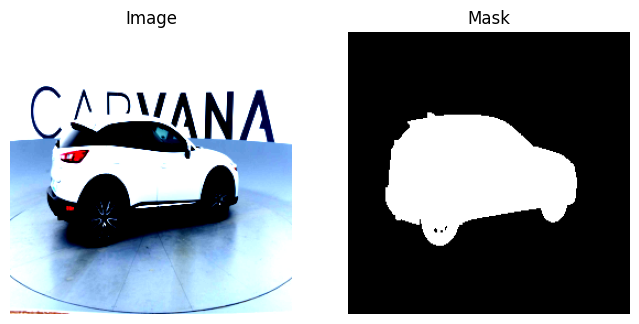

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


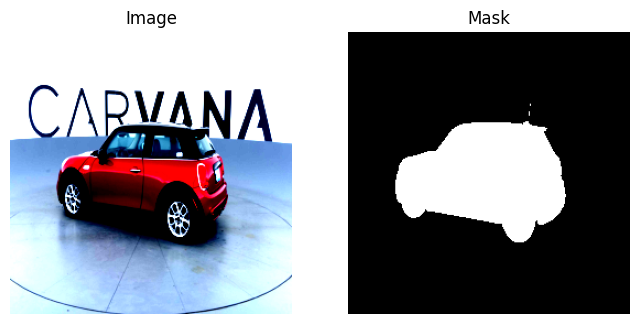

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


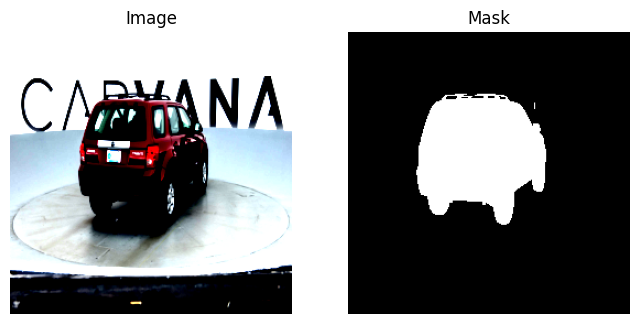

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


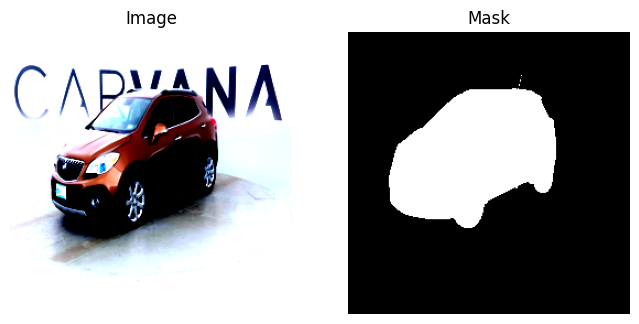

In [39]:
import matplotlib.pyplot as plt

for i in range(masks.shape[0]):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mask = masks[i].squeeze().cpu().numpy()

    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    plt.axis('off')
    
    plt.show()